## Exercice 2
In this exercice, the unemployment rate in switzerland will be displayed in the map. The unemployment rate in the dataset corresponds to every citizen looking for a job (they can be employed temporary by the unemployment placement) for a job divided py the population number. The unemployment rate correspond to the September 2017 statistics.
The following strategy was applied in order to plot the map:
- First, the dataset is imported into a dataframe and imported to obtain the cantons as rows and the unemployment rate, the registered unemployed, and the population asking for job
- A common language needs to be found in order to match the cantons data obtain in the unemployment website and the topojson file that contains the description of the cantons in the map. It was noted that the cantons are written in German in the topojson file but the acronyms are also available. Since the dataframe is in french a new Excel file containing the cantons with their acronyms (VS, ZH, GE,...) is imported in a second dataframe. The 2 dataframes are merged which means a new columns with the cantons acronyms is added
- The next step consist of reading the topojson file and display the cantons border
- Finally, the choroplets map is created with the dataframe (columns cantons acronyms and Taux de chomage) and the topojson file

In [105]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import folium
import json


dfTauxChomage=pd.read_excel("2_1 Taux de chômage.xlsx")
dfTauxChomage=dfTauxChomage[["2.1 Taux de chômage",'Unnamed: 2','Unnamed: 3','Unnamed: 4']]
dfTauxChomage=dfTauxChomage.rename(columns={"2.1 Taux de chômage":"Canton",
    'Unnamed: 2':"Taux de chomage",'Unnamed: 3':'Chômeurs inscrits','Unnamed: 4':'Demandeurs d\'emplois'})
dfTauxChomage=dfTauxChomage.loc[3:29]
dfTauxChomage['Taux de chomage']=list(map(lambda x: float(x),dfTauxChomage['Taux de chomage']))
dfAcronym=pd.read_excel("cantons_acronyms.xlsx")
dfTauxChomage=pd.merge(dfTauxChomage,dfAcronym,on='Canton',how='inner')
dfTauxChomage.head(5)

,Canton,Taux de chomage,Chômeurs inscrits,Demandeurs d'emplois,Cantons Acronyms
0,Zurich,3.3,27225,6931,ZH
1,Berne,2.4,13658,4727,BE
2,Lucerne,1.7,3885,2871,LU
3,Uri,0.6,112,145,UR
4,Schwyz,1.7,1455,774,SZ


In [106]:
m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=7)  

topo_path = r"topojson/ch-cantons.topojson.json"
topo_json_data = open(topo_path)

folium.TopoJson(open(r"topojson/ch-cantons.topojson.json"),
                'objects.cantons',
                name='topojson',
               ).add_to(m)

file=json.load(topo_json_data)

m.choropleth(geo_data=file, data=dfTauxChomage,
             columns=['Cantons Acronyms', 'Taux de chomage'],
             key_on='id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment rate (%)',
             topojson='objects.cantons'
             )
m

The swiss unemployment rate include every citizen looking for a job. We can adapt this rate to find the rate of the population who are register as unemployed and do not have a job.
In order to adapt our unemployment rate, we need need the number of registerd unemployed people and the number of people asking for a job.

To find this rate, we need the active population in each canton : 

\begin{equation}
  Active\ population\ in\ canton\ =\ \frac{Unemployment\ rate}{People\ looking\ for\ a\ job\ unregistered\ +\ Registered\ people\ (unemployed)}\
\end{equation}

Then the adapted unemployed rate which corresponds to the registered unemployed people rate is derieved :

\begin{equation}
   Registered\ unemployed\ people\ rate =\ \frac{Registered\ people\ (unemployed)}{Active\ population\ in\ canton}\
\end{equation}

Then the map is displayed using the same method as the first part of the exercice

In [107]:
listTauxChomage=list(dfTauxChomage['Taux de chomage'])
listChômeursInscrit=list(dfTauxChomage['Chômeurs inscrits'])
listDemandeurEmploi=list(dfTauxChomage['Demandeurs d\'emplois'])

#We need to adapt the rate 
listAdaptedEmploymentRate=[x*y/(y+z) for x,y,z in zip(listTauxChomage,listChômeursInscrit,listDemandeurEmploi)]
dfTauxChomage['Adapted unemployment rate']=pd.Series(listAdaptedEmploymentRate)

m1 = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=7)  

folium.TopoJson(open(r"topojson/ch-cantons.topojson.json"),
                'objects.cantons',
                name='topojson',
               ).add_to(m1)

m1.choropleth(geo_data=file, data=dfTauxChomage,
             columns=['Cantons Acronyms', 'Adapted unemployment rate'],
             key_on='id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Adapted unemployment rate (%)',
             topojson='objects.cantons'
             )
m1

In order to study if there is a relation between the 2 different unemployment rate, a simple linear regression is performed using the Swiss unemployment rate as X and the adapted unemployment rate as rate

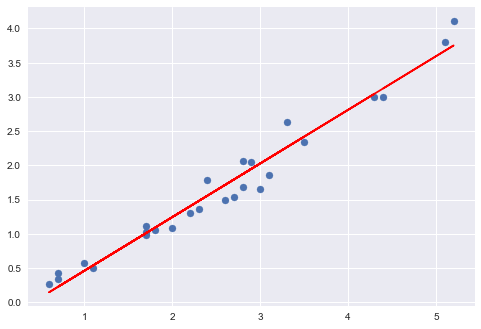

In [108]:
from scipy import stats

def draw_regress(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line1 = intercept + slope*x

    plt.scatter(x,y)
    plt.plot(x,line1,'r')
    plt.show()

draw_regress(dfTauxChomage['Taux de chomage'],pd.Series(listAdaptedEmploymentRate))


As we can see in this linear regression, if a canton has a low unemployment rate, this canton has also few people looking for a job. We could do some other study on how the unemployment rate by age range is comparable with the unemployment rate of the whole active population 

In [ ]:
m.save('Unemployment_rate_switzerland.HTML')
m1.save('Adapted_unemployment_rate_switzerland.HTML')